In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, Normalizer, MinMaxScaler, PolynomialFeatures

from imblearn.over_sampling import SMOTE

import matplotlib

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

#### Щоб не переглядати весь ноутбук ви можете подивитися тільки розділ "Балансування ознак (SMOTE)" (майже в кінці). Там зібрані всі нароботки в одне місце.
На навчальній виборці кросс валідацією вийшло досягти 88%, але на тестовій тільки 58%. Тобто модель перенавчена.
Це результат із чисткою від вибросів через LocalOutlierFactor та додаванням нових ознак через PolynomialFeatures.
Також, було масштабування через QuantileTransformer.

In [2]:
df_wr = pd.read_csv('winequality-red.csv', sep = ';')
df_ww = pd.read_csv('winequality-white.csv', sep = ';')

In [3]:
df_wr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
df_ww

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [5]:
df_wr['red wine'] = 1
df_ww['red wine'] = 0

In [6]:
df = pd.concat([df_wr, df_ww], ignore_index = True)
df.groupby(by = 'red wine').describe(percentiles = [])

fixed acidity                                     volatile acidity  \
                 count      mean       std  min  50%   max            count   
red wine                                                                      
0               4898.0  6.854788  0.843868  3.8  6.8  14.2           4898.0   
1               1599.0  8.319637  1.741096  4.6  7.9  15.9           1599.0   

                                    ...   alcohol                  quality  \
              mean       std   min  ...       std  min   50%   max   count   
red wine                            ...                                      
0         0.278241  0.100795  0.08  ...  1.230621  8.0  10.4  14.2  4898.0   
1         0.527821  0.179060  0.12  ...  1.065668  8.4  10.2  14.9  1599.0   

                                             
              mean       std  min  50%  max  
red wine                                     
0         5.877909  0.885639  3.0  6.0  9.0  
1         5.636023  0.807569  3.0  6.0  8.0  

[2 rows x 72 columns]

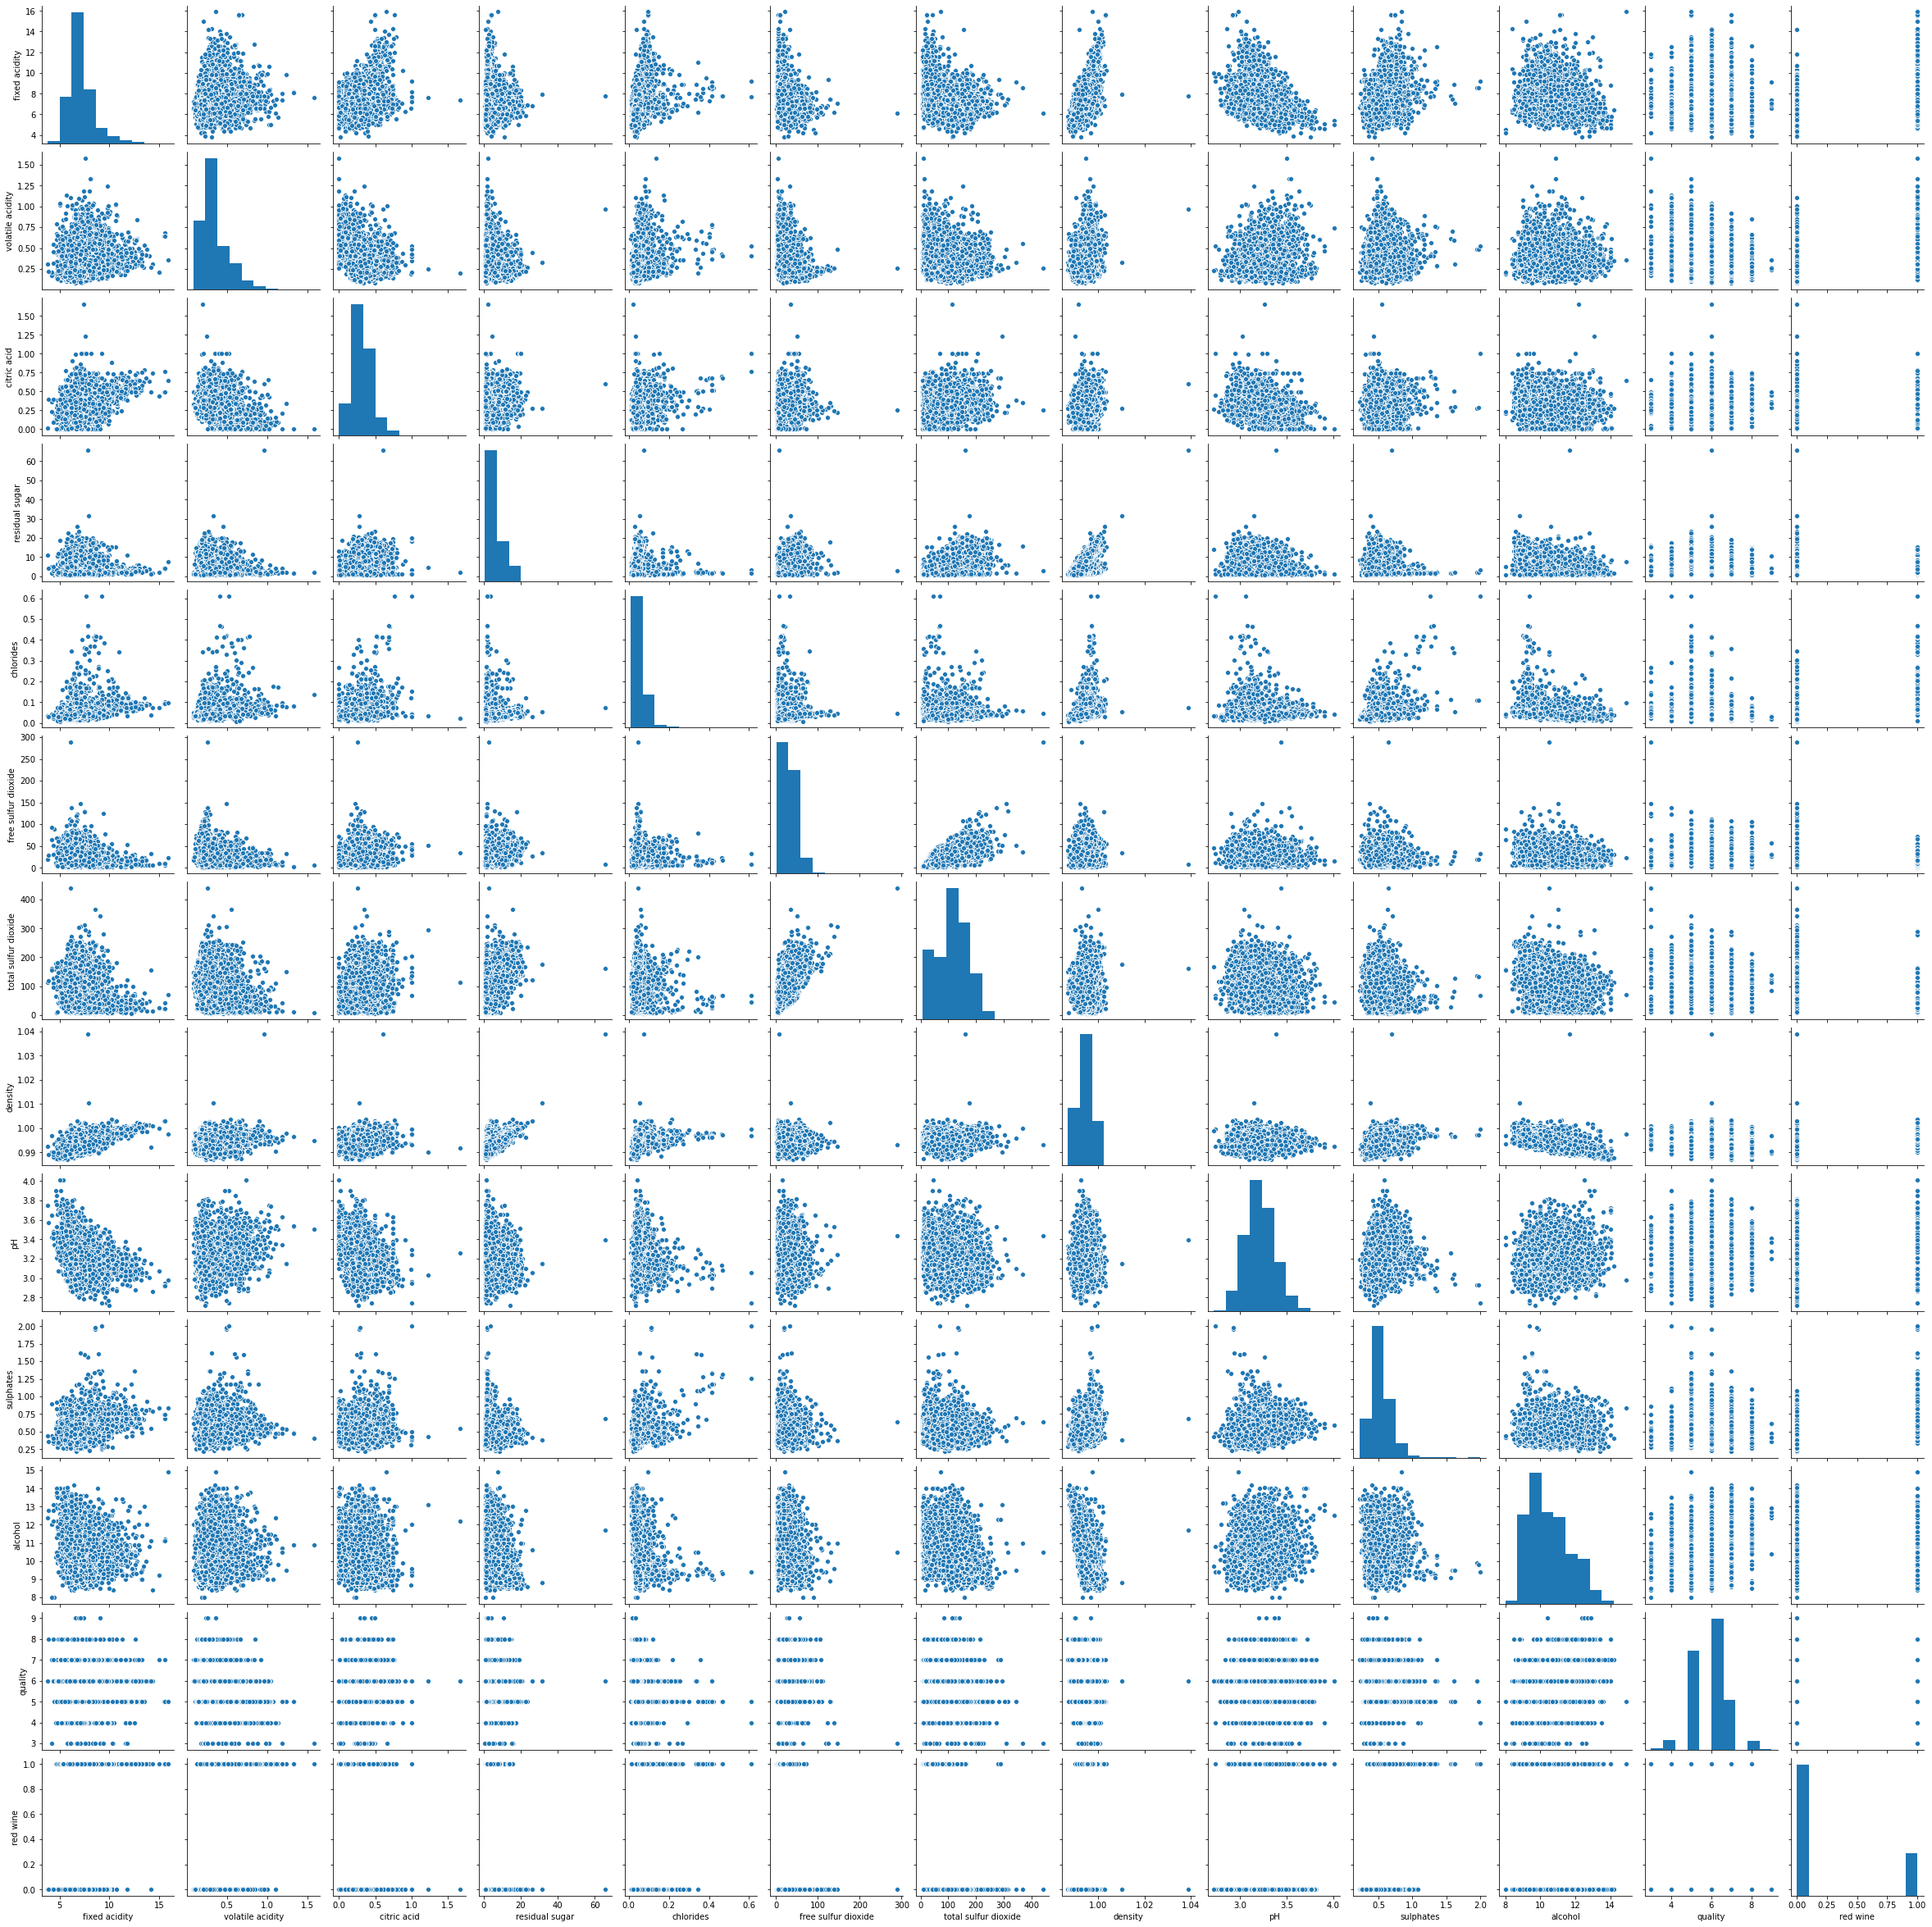

In [35]:
sns.pairplot(df)

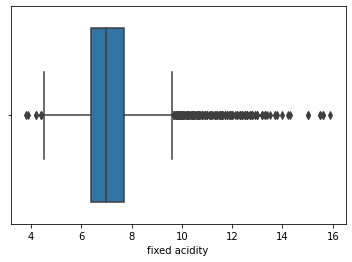

In [7]:
sns.boxplot(df['fixed acidity'])

# Linear regression (quality)

### Linear regression

In [10]:
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(df.drop(['quality'], axis = 1),
                                                            df['quality'],
                                                            test_size = 0.2,
                                                            random_state = 1)

In [11]:
# звичайна лінійна модель
l_model_q = LinearRegression().fit(X_train_q, y_train_q)
y_pred = np.round(l_model_q.predict(X_test_q))
accuracy_score(y_test_q, y_pred)

0.5361538461538462

### Cross validation

In [14]:
# пошук найбільшої оцінки за кросс валідацією (1 спосіб)

k_fold = KFold(n_splits = 5, shuffle = True, random_state = 2)

scores = list()
l_models = list()


for train_i, test_i in k_fold.split(df):
    
    X_train = df.iloc[train_i].drop('quality', axis = 1)
    y_train = df.iloc[train_i]['quality']
    X_test = df.iloc[test_i].drop('quality', axis = 1)
    y_test = df.iloc[test_i]['quality']
    
    l_model = LinearRegression().fit(X_train, y_train)
    l_models.append(l_model)
    
    y_pred = np.round(l_model.predict(X_test))
    scores.append(accuracy_score(y_test, y_pred))
    

l_model = l_models[scores.index(max(scores))]
scores

[0.5423076923076923,
 0.49230769230769234,
 0.5596612779060816,
 0.5280985373364127,
 0.5381062355658198]

### SGD Regressor

Accuracy score: 0.5476923076923077


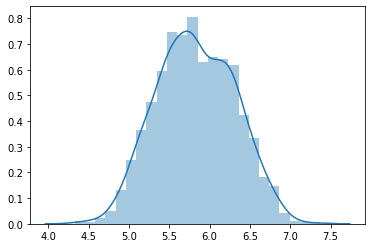

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis = 1),
                                                    df['quality'],
                                                    test_size = 0.2,
                                                    random_state = 2)

scaler = StandardScaler().fit(df.drop('quality', axis = 1))
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

SGDreg = SGDRegressor(loss = 'squared_loss', 
                      penalty = 'l2',
                      )
SGDreg = SGDreg.fit(X_train_t, y_train)
y_pred = SGDreg.predict(X_test_t)

print('Accuracy score:', accuracy_score(y_test, np.round(y_pred)))
sns.distplot(y_pred)

# KNeighborsClassifier (classification quality)

In [48]:
# функція підбору к-ті сусідів та порівняння сирих даних із обробленими (масштабовані)
def selectionNNeighbors(X_train, X_train_t, y_train, n_neighbors):

    res_accuracy = pd.DataFrame(columns = ['n neighbors', 'accuracy raw data', 'accuracy scaler data'])

    for n in tqdm(range(1, n_neighbors + 1)):
        KNN = KNeighborsClassifier(n_neighbors = n)
        res_accuracy = res_accuracy.append({'n neighbors': n, 
                                            'accuracy raw data': cross_val_score(KNN, X_train, y_train).mean(), 
                                            'accuracy scaler data': cross_val_score(KNN, X_train_t, y_train).mean()
                                           }, ignore_index = True)

    res_accuracy = res_accuracy.set_index('n neighbors')
    return res_accuracy


Max score:
accuracy raw data       0.543967
accuracy scaler data    0.608621
dtype: float64


,accuracy raw data,accuracy scaler data
n neighbors,,
1.0,0.543967,0.608621
2.0,0.481239,0.558781
3.0,0.462186,0.549351


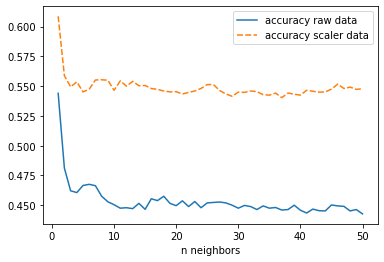

In [98]:
# StandartScaler
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis = 1),
                                                    df['quality'],
                                                    test_size = 0.2,
                                                    random_state = 1)

# приведення до нормального розподілу
scaler = StandardScaler().fit(df.drop('quality', axis = 1))
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

res_ac = selectionNNeighbors(X_train, X_train_t, y_train, 50)

print('Max score:\n{}'.format(res_ac.max()))
sns.lineplot(data = res_ac)
res_ac.head(3)


Max score:
accuracy raw data       0.543967
accuracy scaler data    0.607659
dtype: float64


,accuracy raw data,accuracy scaler data
n neighbors,,
1.0,0.543967,0.607659
2.0,0.481239,0.548390
3.0,0.462186,0.542424


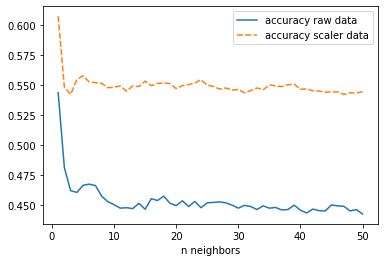

In [101]:
# RobustScaler
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis = 1),
                                                    df['quality'],
                                                    test_size = 0.2,
                                                    random_state = 1)
scaler = RobustScaler().fit(df.drop('quality', axis = 1))
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

res_ac = selectionNNeighbors(X_train, X_train_t, y_train, 50)

print('Max score:\n{}'.format(res_ac.max()))
sns.lineplot(data = res_ac)
res_ac.head(3)


Max score:
accuracy raw data       0.543967
accuracy scaler data    0.609579
dtype: float64


,accuracy raw data,accuracy scaler data
n neighbors,,
1.0,0.543967,0.609579
2.0,0.481239,0.558589
3.0,0.462186,0.542231


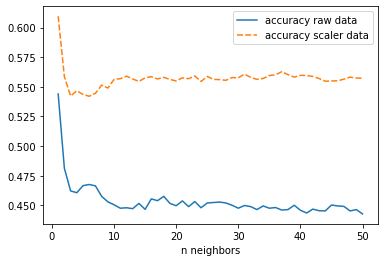

In [102]:
# QuantileTransformer
X_train, X_test, y_train, y_test = train_test_split(df.drop(['quality'], axis = 1),
                                                    df['quality'],
                                                    test_size = 0.2,
                                                    random_state = 1)
scaler = QuantileTransformer().fit(df.drop('quality', axis = 1))
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

res_ac = selectionNNeighbors(X_train, X_train_t, y_train, 50)

print('Max score:\n{}'.format(res_ac.max()))
sns.lineplot(data = res_ac)
res_ac.head(3)

# Додавання нових фіч (не вийшло)

Coef: [ 0.04337692 -0.25587152 -0.01777066  0.22494012 -0.04771394  0.08144254
 -0.08914274 -0.2097145   0.05487595  0.09334007  0.3159898   0.11717064]


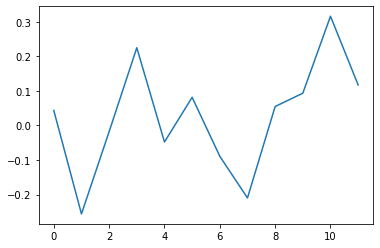

In [56]:
# перегляд впливовості метрик
print('Coef:', SGDreg.coef_)
sns.lineplot(data = SGDreg.coef_)
#видно, що 1, 3 та 10 коеф. мають найбільший вплив
MOST_INF_FEATURES = df.columns[[1, 3, 10]]
# видно, що коеф. 4, 5, 6, 8, 9 мають найменший вплив
LEAST_INF_FEATURES = df.columns[[4, 5, 6, 8, 9]]

#прибирання невпливових ознак не допомогло

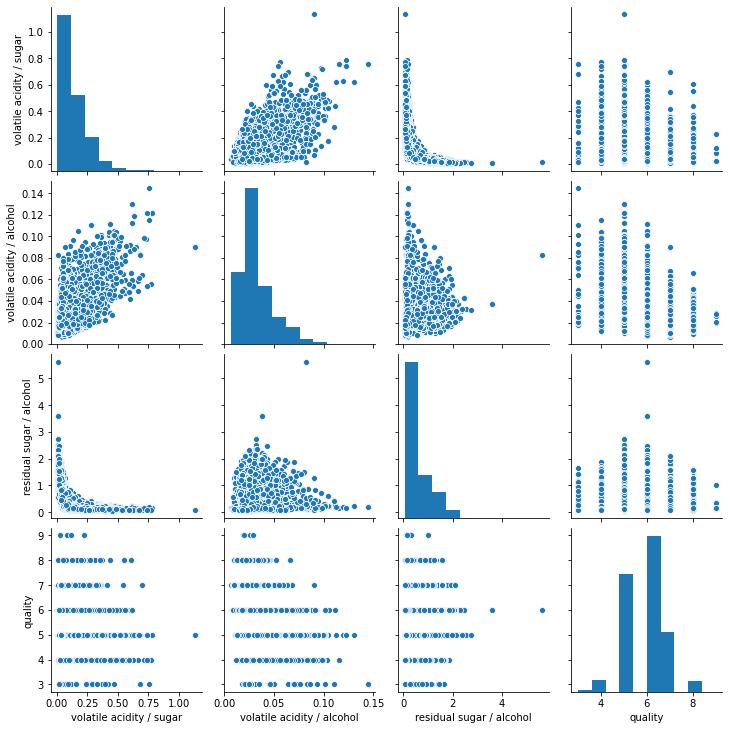

In [105]:
df['volatile acidity / sugar'] = df['volatile acidity'] / df['residual sugar']
df['volatile acidity / alcohol'] = df['volatile acidity'] / df['alcohol']
df['residual sugar / alcohol'] = df['residual sugar'] / df['alcohol']
sns.pairplot(df[['volatile acidity / sugar', 'volatile acidity / alcohol', 'residual sugar / alcohol', 'quality']])


 # Чистка від вибросів через LocalOutlierFactor та додавання нових ознак через PolynomialFeatures


Max score:
accuracy raw data       0.539425
accuracy scaler data    0.604999
dtype: float64


,accuracy raw data,accuracy scaler data
n neighbors,,
1.0,0.539425,0.604999
2.0,0.478141,0.555623
3.0,0.458624,0.541960


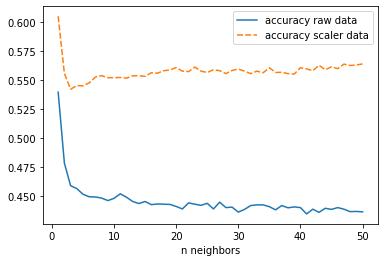

In [106]:
# Створення навчальної вибірки
X_train, X_test, y_train, y_test = train_test_split(df.drop(['quality'], axis = 1),
                                                    df['quality'],
                                                    test_size = 0.2,
                                                    random_state = 1)

# очистка від вибросів
LOF = LocalOutlierFactor(n_neighbors = 10).fit_predict(X_train)
X_train = X_train[(pd.Series(LOF).map({1: True, -1: False})).to_list()]
y_train = y_train[(pd.Series(LOF).map({1: True, -1: False})).to_list()]

# генерація поліноміальних ознак 
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

# приведення до нормального розподілу
scaler = QuantileTransformer().fit(X_train)
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

res_ac = selectionNNeighbors(X_train, X_train_t, y_train, 50)

print('Max score:\n{}'.format(res_ac.max()))
sns.lineplot(data = res_ac)
res_ac.head(3)

# Балансування ознак (SMOTE)

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

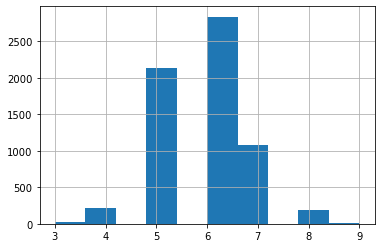

In [108]:
df['quality'].hist()
df['quality'].value_counts()

In [20]:
X_test.shape

(1300, 12)


Max score:
accuracy raw data       0.873076
accuracy scaler data    0.879902
dtype: float64
Wall time: 2min 16s


,accuracy raw data,accuracy scaler data
n neighbors,,
1.0,0.873076,0.879902
2.0,0.831851,0.848821
3.0,0.812864,0.832435


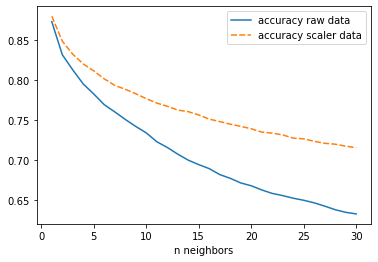

In [63]:
%%time
# Створення навчальної вибірки
X_train, X_test, y_train, y_test = train_test_split(df.drop(['quality'], axis = 1),
                                                    df['quality'],
                                                    test_size = 0.2,
                                                    random_state = 1)

# очистка від вибросів
LOF = LocalOutlierFactor(n_neighbors = 5).fit_predict(X_train)
X_train = X_train[(pd.Series(LOF).map({1: True, -1: False})).to_list()]
y_train = y_train[(pd.Series(LOF).map({1: True, -1: False})).to_list()]

# генерація поліноміальних ознак 
# poly = PolynomialFeatures(2)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


# балансування навчальної вибірки
oversample = SMOTE(k_neighbors = 3)
X_train, y_train = oversample.fit_resample(X_train, y_train)


# приведення до нормального розподілу
scaler = QuantileTransformer().fit(X_train)
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)


res_ac = selectionNNeighbors(X_train, X_train_t, y_train, 30)

print('Max score:\n{}'.format(res_ac.max()))
sns.lineplot(data = res_ac)
res_ac.head(3)

In [64]:
# оцінка тестових даних
KNeighborsClassifier(n_neighbors = 1).fit(X_train_t, y_train).score(X_test_t, y_test)


0.5792307692307692

# Linear regression (classification red wine)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, : -1],
                                                   df.iloc[:, -1],
                                                   test_size = 0.2,
                                                   random_state = 1)

l_model_c = LinearRegression().fit(X_train, y_train)
y_pred = np.round(l_model_c.predict(X_test)).astype(np.bool)

print('Accuracy score:', accuracy_score(y_test, y_pred))
print('Precision score:', precision_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Accuracy score: 0.9923076923076923
Precision score: 0.9864406779661017
Recall score: 0.9797979797979798
F1 score: 0.983108108108108
